In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from torch import nn
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets
from torch.optim import Adam, Optimizer
from torch.nn import functional as F

from torchsummary import summary
from tqdm.notebook import tqdm

# Настройки

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/Colab_Notebooks/made/deep_ml_base/laba-dataset.zip

Archive:  /content/drive/MyDrive/Colab_Notebooks/made/deep_ml_base/laba-dataset.zip
  inflating: samples/226md.png       
  inflating: samples/22d5n.png       
  inflating: samples/2356g.png       
  inflating: samples/23mdg.png       
  inflating: samples/23n88.png       
  inflating: samples/243mm.png       
  inflating: samples/244e2.png       
  inflating: samples/245y5.png       
  inflating: samples/24f6w.png       
  inflating: samples/24pew.png       
  inflating: samples/25257.png       
  inflating: samples/253dc.png       
  inflating: samples/25egp.png       
  inflating: samples/25m6p.png       
  inflating: samples/25p2m.png       
  inflating: samples/25w53.png       
  inflating: samples/264m5.png       
  inflating: samples/268g2.png       
  inflating: samples/28348.png       
  inflating: samples/28x47.png       
  inflating: samples/2b827.png       
  inflating: samples/2bg48.png       
  inflating: samples/2cegf.png       
  inflating: samples/2cg58.png       
  in

# Data

## Структура

Изучим для начала структуру данных.

In [ ]:
import os

Я не уверен почему в архиве 2 папки с одинаковым названием. Пока положим, что это тест и трейн данные.

In [ ]:
WD = Path("/content")
DATA = WD / "samples"
DATA_TEST = DATA / "samples"

names = []
sample_names = []

In [ ]:
def read_names(path: Path) -> np.ndarray:
    labels = []
    for name in os.listdir(path):
        if not os.path.isdir(path / name):
            label = name.split(".")[0]
            labels.append(label)
    
    return np.array(labels)


In [ ]:
labels = read_names(DATA)
test_labels = read_names(DATA_TEST)

# размер выборок
print("train size: ", labels.shape)
print("test_size: ", test_labels.shape)

print(len(set(labels).intersection(set(test_labels))))

train size:  (1070,)
test_size:  (1070,)
1070


Видимо это неправда. Просто продублирована папка. Имеем всего 1070 изображений (визуально картинки тоже не отличаются).

In [ ]:
# длины слов
assert len(max(labels, key=len)) == len(min(labels, key=len))
print("Длина всегда ", len(max(labels, key=len)))


Длина всегда  5


Используются ли одни и те же буквы в одном слове 

In [ ]:
count = 0
for name in labels:
    new_name = np.unique(list(name))
    if len(new_name) != len(name):
        count += 1
        print("Duplicated char: ", "".join(new_name), name)

print("Total: ", count)


Duplicated char:  6enp 6e6pn
Duplicated char:  48py 84py4
Duplicated char:  27ex x277e
Duplicated char:  7np pn7pn
Duplicated char:  4nw n4wwn
Duplicated char:  35fg 5f3gf
Duplicated char:  24e 244e2
Duplicated char:  3ben 3ebnn
Duplicated char:  34mn 4n3mn
Duplicated char:  4egw gegw4
Duplicated char:  4bdn b4ndb
Duplicated char:  3dfn 3nfdn
Duplicated char:  7dwx xwx7d
Duplicated char:  dpx ddxpp
Duplicated char:  56bd b55d6
Duplicated char:  2px px2xp
Duplicated char:  348b 34b84
Duplicated char:  cgxy xgcxy
Duplicated char:  5fnx xnfx5
Duplicated char:  cnwy cnwyc
Duplicated char:  7fgn g7gnf
Duplicated char:  46mw 4w6mw
Duplicated char:  67bw 6wb76
Duplicated char:  578w 8w875
Duplicated char:  2348 28348
Duplicated char:  4nwx nn4wx
Duplicated char:  23bw 3w2bw
Duplicated char:  2efg f2fge
Duplicated char:  7nwy yw7ny
Duplicated char:  58fx f858x
Duplicated char:  bcg cgcgb
Duplicated char:  45bg g55b4
Duplicated char:  8bfn nnf8b
Duplicated char:  dpwy ppwyd
Duplicated char:  6f

Сделаем словарь буква -> id

In [ ]:
chars = list("".join(labels))
chars = sorted(np.unique(chars))

In [ ]:
id_to_ch = {i + 1: ch for i, ch in enumerate(chars)}
id_to_ch[0] = "-"
ch_to_id = {ch: i for i, ch in id_to_ch.items()}

In [ ]:
id_to_ch

{1: '2',
 2: '3',
 3: '4',
 4: '5',
 5: '6',
 6: '7',
 7: '8',
 8: 'b',
 9: 'c',
 10: 'd',
 11: 'e',
 12: 'f',
 13: 'g',
 14: 'm',
 15: 'n',
 16: 'p',
 17: 'w',
 18: 'x',
 19: 'y',
 0: '-'}

## Dataset

In [ ]:
from typing import Optional, Union, List, Dict


class CaptchaDataset(Dataset):
    """Captcha dataset."""

    def __init__(
        self, 
        root_dir: Union[Path, str], 
        names: Optional[List[str]] = None,
        encode_dct: Dict[str, str] = None, 
        transform = None, 
        use_cache: bool = False):
        """
        Args:
            root_dir (string, Path): Directory with all the images.
            names (np.ndarray, optional): full names (with format) of files to use. If None all images from root_dir will be used.
            encode_dct (Dict[str, str]): dict to encode name for CTC loss.
            transform (callable, optional): Optional transform to be applied
                on a sample.
            use_cache (bool): preload all images to RAM.
        """
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.encode_dct = encode_dct

        if names is None:
            self.names = []
            for name in os.listdir(root_dir):
                rname = self.root_dir / name
                if not os.path.isdir(rname):
                    self.names.append(name)
        else:
            self.names = names
        
        if use_cache:
            self.data = self._load_data()
        else:
            self.data = None
            

    def __len__(self):
        return len(self.names)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        if self.data is not None:
            img = self.data[idx]['img']
            name = self.data[idx]['name']
            enc_name = self.data[idx]['enc_name']
        else:
            name = self.names[idx]
            path = self.root_dir / name
            img = cv2.imread(str(path))
            name = name.split('.')[0]
            enc_name = self._encode(name.split('.')[0])

        if self.transform:
            img = self.transform(img)

        return img, enc_name, name

    def _load_data(self):
        data = []
        for name in self.names:
            path = self.root_dir / name
            sample = {
                'img': cv2.imread(str(path)),
                'name': name.split('.')[0],
                'enc_name': self._encode(name.split('.')[0])}
            data.append(sample)
        
        return data
    
    def _encode(self, name: str):
        if self.encode_dct is None:
            return name
        return torch.tensor([self.encode_dct[ch] for ch in name], dtype=torch.long)

In [ ]:
from typing import List


def visualize(imgs: List[torch.Tensor], labels: List[str]):

    h = len(imgs) // 2 + len(imgs) % 2
    w = 2
    spb = f"{2}{h}"
    fig = plt.figure(figsize=(h*2, w*2), dpi=100)

    for ind, sample in enumerate(zip(imgs, labels)):
        img, label = sample
        img = img / 2 + 0.5
        npimg = img.detach().numpy()
        pos = int(f"{spb}{ind + 1}")
        ax = fig.add_subplot(pos)
        ax.set_title(label)
        ax.imshow(np.transpose(npimg, (1, 2, 0)))

    plt.show()

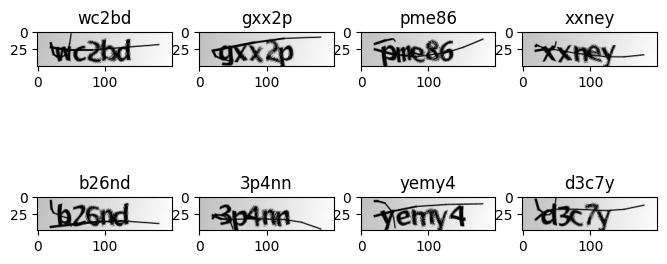

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

captchads = CaptchaDataset(DATA, transform=transform, use_cache=True)
imgs = [captchads[i][0] for i in range(8)]
labels = [captchads[i][1] for i in range(8)]

visualize(imgs, labels)

### Сравнение кеша

In [ ]:
%%timeit
i = np.random.randint(0, len(captchads))
captchads[i]

233 µs ± 114 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [ ]:
captchads = CaptchaDataset(DATA, transform=transform, use_cache=False)

In [ ]:
%%timeit
i = np.random.randint(0, len(captchads))
captchads[i]

592 µs ± 91.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## Train-Test split

Теоретически, чтоб не обучиться к параметрам, надо делить данные на train-test-validation, но пока обойдёмся просто train-test.

In [ ]:
from sklearn.model_selection import train_test_split

all_names = os.listdir(DATA_TEST)
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )

train_names, test_names = train_test_split(all_names, test_size=0.3)
train_dataset = CaptchaDataset(
    DATA,
    train_names,
    transform=transform,
    encode_dct=ch_to_id,
    use_cache=True,
)
test_dataset = CaptchaDataset(
    DATA,
    test_names,
    encode_dct=ch_to_id,
    transform=transform,
    use_cache=True,
)

train_bs = 16
test_bs = 8

train_loader = DataLoader(train_dataset, batch_size=train_bs, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=test_bs, shuffle=False)

In [ ]:
full_dataset = CaptchaDataset(
    DATA,
    transform=transform,
    encode_dct=ch_to_id
)

full_loader = DataLoader(full_dataset, batch_size=16)

In [ ]:
dataiter = iter(test_loader)
images, target, labels = next(dataiter)

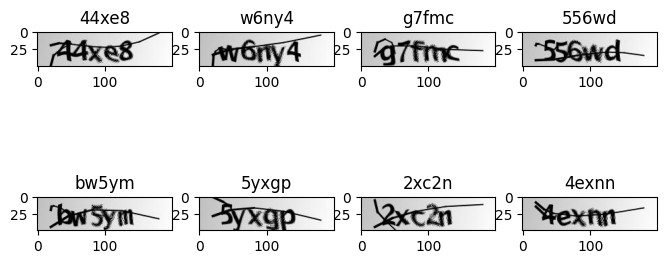

In [ ]:
visualize(images, labels)

# Model

In [ ]:
class CaptchaModel(nn.Module):
    def __init__(self, decode_dct: Dict[int, str], in_channels: int = 3, in_h: int = 50, in_w: int = 200):
        num_of_classes = len(decode_dct)
        self.decode_dct = decode_dct

        super().__init__()
        self.conv_part = nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels = 32,
                kernel_size=(3, 3),
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=(2, 2),
                stride=2,
            ),
            nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=(3, 3),
                padding=1,
            ),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=(2, 2),
                stride=2,
            )
        )
        out_conv = 64 * (in_h // 4)
        self.conv_to_lstm = nn.Sequential(
            nn.Linear(out_conv, 64),
            nn.ReLU(),
            nn.Dropout(p=0.2),
        )
        self.first_lstm = nn.LSTM(64, 128, bidirectional=True, dropout=0.2)
        self.second_lstm = nn.LSTM(256, 64, bidirectional=True, dropout=0.2)
        self.classification = nn.Sequential(
            nn.Linear(128, num_of_classes),
            nn.LogSoftmax(dim=-1)
        )

    def forward(self, x: torch.Tensor):
        x = self.conv_part(x)
        x = torch.transpose(x, -1, 1)
        new_shape = (x.shape[0], x.shape[1], x.shape[2] * x.shape[3])
        x = torch.reshape(x, new_shape)
        x = self.conv_to_lstm(x)
        x, _ = self.first_lstm(x)
        x, _ = self.second_lstm(x)

        return self.classification(x)
    
    def decode_out(self, logprob: torch.Tensor, return_raw: bool = False) -> List[str]:
        dvc = torch.device('cpu')
        amax = logprob.to(dvc).detach().argmax(dim=-1).numpy()
        decoded = np.vectorize(self.decode_dct.get)(amax)

        words = []
        for code in decoded:
            word = []
            for i, ch in enumerate(code):
                if (i == 0 or ch != code[i - 1]) and ch != '-':
                    word.append(ch)
                elif i == 0 and ch == '':
                    word.append('')
            words.append("".join(word))

        if return_raw:
            return ["".join(raw) for raw in decoded]
        return words


In [ ]:
mdl = CaptchaModel(id_to_ch)
print(mdl)

CaptchaModel(
  (conv_part): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_to_lstm): Sequential(
    (0): Linear(in_features=768, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
  )
  (first_lstm): LSTM(64, 128, bidirectional=True)
  (second_lstm): LSTM(256, 64, bidirectional=True)
  (classification): Sequential(
    (0): Linear(in_features=128, out_features=20, bias=True)
    (1): LogSoftmax(dim=-1)
  )
)


In [ ]:
logprob = mdl(images)
ctc_loss = nn.CTCLoss()
input_lengths = tuple(50 for _ in range(8))
target_lengths = tuple(5 for _ in range(8))

loss = ctc_loss(logprob.transpose(0, 1), labels, input_lengths, target_lengths)
loss.item()

25.085771560668945

In [ ]:
mdl.decode_out(logprob)

['6',
 '6',
 '6',
 '676767676',
 '6767676767676767676',
 '676767676',
 '767676767676',
 '76767676']

# Train

In [ ]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.2/517.2 KB 33.2 MB/s eta 0:00:00


In [ ]:
from torchmetrics.functional import char_error_rate

def show_example(model: CaptchaModel, test_img: torch.Tensor):
    pred_labels = model.decode_out(model(test_img))
    visualize(test_img.cpu(), pred_labels)

In [ ]:
def grad_norm(model: nn.Module):
    total_norm = 0
    parameters = [p for p in model.parameters() if p.grad is not None and p.requires_grad]
    for p in parameters:
        param_norm = p.grad.detach().data.norm(2)
        total_norm += param_norm.item() ** 2
    total_norm = total_norm ** 0.5
    return total_norm

In [ ]:
import typing as tp


def train(
    model: CaptchaModel,
    optim: Optimizer,
    device: tp.Any,
    trainloader: DataLoader,
    testloader: DataLoader,
    clip_grad: float,
    epochs: int = 100,
    verbose_ep: int = 10,
) -> tp.Tuple[tp.List[float], tp.List[float]]:
    model.to(device)

    ctc_loss = nn.CTCLoss(zero_infinity=True)

    train_loss_history = []
    test_loss_history = []

    train_input_lengths = tuple(50 for _ in range(trainloader.batch_size))
    train_target_lengths = tuple(5 for _ in range(trainloader.batch_size))

    test_input_lengths = tuple(50 for _ in range(testloader.batch_size))
    test_target_lengths = tuple(5 for _ in range(testloader.batch_size))

    dataiter = iter(testloader)
    test_img, _, _ = next(dataiter)
    test_img = test_img.to(device)[:8]

    show_example(model, test_img)

    for ep in range(1, epochs + 1):
        total_batches = 0
        total_loss = 0
        cer = 0

        model.train()

        for batch, codes, labels in tqdm(trainloader, desc=f"Epoch #{ep}"):
            total_batches += 1
            img = batch.to(device)
            logprobs = model(img)

            input_lengths = tuple(50 for _ in range(batch.shape[0]))
            target_lengths = tuple(5 for _ in range(batch.shape[0]))

            loss = ctc_loss(
                logprobs.transpose(0, 1),
                codes,
                input_lengths,
                target_lengths,
            )

            optim.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), clip_grad)
            optim.step()
            total_loss += loss.item()

            cer += char_error_rate(
                model.decode_out(logprobs),
                labels,
            )

        train_loss_history.append(total_loss / total_batches)
        print(f"Train Epoch {ep} | Mean batch loss: {total_loss / total_batches} | Mean CER: {cer / total_batches}")

        model.eval()
        with torch.no_grad():
            total_batches = 0
            total_loss = 0
            cer = 0

            for batch, codes, labels in tqdm(testloader, desc=f"Epoch #{ep}"):
                total_batches += 1
                img = batch.to(device)
                logprobs = model(img)

                input_lengths = tuple(50 for _ in range(batch.shape[0]))
                target_lengths = tuple(5 for _ in range(batch.shape[0]))

                loss = ctc_loss(
                    logprobs.transpose(0, 1),
                    codes,
                    input_lengths,
                    target_lengths,
                )

                total_loss += loss.item()

                cer += char_error_rate(
                    model.decode_out(logprobs),
                    labels,
                )
        
            test_loss_history.append(total_loss / total_batches)
            print(f"Test Epoch {ep} | Mean batch loss: {total_loss / total_batches} | Mean CER: {cer / total_batches}")

        if ep % verbose_ep == 0:
            show_example(model, test_img.to(device))
        
    return train_loss_history, test_loss_history

In [ ]:
# train_loader, test_loader

model = CaptchaModel(id_to_ch)
optim = Adam(model.parameters(), lr=1e-4)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


CaptchaModel(
  (conv_part): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_to_lstm): Sequential(
    (0): Linear(in_features=768, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
  )
  (first_lstm): LSTM(64, 128, dropout=0.2, bidirectional=True)
  (second_lstm): LSTM(256, 64, dropout=0.2, bidirectional=True)
  (classification): Sequential(
    (0): Linear(in_features=128, out_features=20, bias=True)
    (1): LogSoftmax(dim=-1)
  )
)

Посмотрим на клипинг костанту.

In [ ]:
norm = []
model.to(device)
ctc_loss = nn.CTCLoss(zero_infinity=True)
model.train()
for _ in range(10):
    for batch, codes, labels in tqdm(train_loader):
        img = batch.to(device)
        logprobs = model(img)

        input_lengths = tuple(50 for _ in range(batch.shape[0]))
        target_lengths = tuple(5 for _ in range(batch.shape[0]))

        loss = ctc_loss(
            logprobs.transpose(0, 1),
            codes,
            input_lengths,
            target_lengths,
        )

        optim.zero_grad()
        loss.backward()
        norm.append(grad_norm(model))
        optim.step()


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

In [ ]:
clip = np.median(norm) / 10

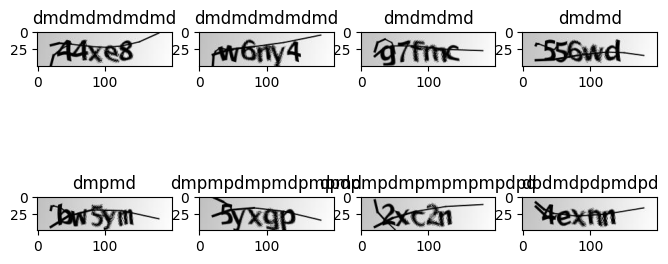

Epoch #1:   0%|          | 0/47 [00:00<?, ?it/s]

Train Epoch 1 | Mean batch loss: 6.373846936733164 | Mean CER: 1.02765953540802


Epoch #1:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 1 | Mean batch loss: 3.3324140397513786 | Mean CER: 1.0


Epoch #2:   0%|          | 0/47 [00:00<?, ?it/s]

Train Epoch 2 | Mean batch loss: 3.3007015979036374 | Mean CER: 1.0


Epoch #2:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 2 | Mean batch loss: 3.303528169306313 | Mean CER: 1.0


Epoch #3:   0%|          | 0/47 [00:00<?, ?it/s]

Train Epoch 3 | Mean batch loss: 3.2855431323355817 | Mean CER: 1.0


Epoch #3:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 3 | Mean batch loss: 3.2694544385119184 | Mean CER: 1.0


Epoch #4:   0%|          | 0/47 [00:00<?, ?it/s]

Train Epoch 4 | Mean batch loss: 3.2806414695496255 | Mean CER: 1.0


Epoch #4:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 4 | Mean batch loss: 3.2703476533657168 | Mean CER: 1.0


Epoch #5:   0%|          | 0/47 [00:00<?, ?it/s]

Train Epoch 5 | Mean batch loss: 3.2789693994725004 | Mean CER: 1.0


Epoch #5:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 5 | Mean batch loss: 3.2689787760013487 | Mean CER: 1.0


Epoch #6:   0%|          | 0/47 [00:00<?, ?it/s]

Train Epoch 6 | Mean batch loss: 3.27777166062213 | Mean CER: 1.0


Epoch #6:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 6 | Mean batch loss: 3.2715712116985785 | Mean CER: 1.0


Epoch #7:   0%|          | 0/47 [00:00<?, ?it/s]

Train Epoch 7 | Mean batch loss: 3.2751481380868466 | Mean CER: 1.0


Epoch #7:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 7 | Mean batch loss: 3.262423701402618 | Mean CER: 1.0


Epoch #8:   0%|          | 0/47 [00:00<?, ?it/s]

Train Epoch 8 | Mean batch loss: 3.2736755685603365 | Mean CER: 1.0


Epoch #8:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 8 | Mean batch loss: 3.266397115660877 | Mean CER: 1.0


Epoch #9:   0%|          | 0/47 [00:00<?, ?it/s]

Train Epoch 9 | Mean batch loss: 3.274709239919135 | Mean CER: 1.0


Epoch #9:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 9 | Mean batch loss: 3.258340416885004 | Mean CER: 1.0


Epoch #10:   0%|          | 0/47 [00:00<?, ?it/s]

Train Epoch 10 | Mean batch loss: 3.273615578387646 | Mean CER: 1.0


Epoch #10:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 10 | Mean batch loss: 3.2605010300147823 | Mean CER: 1.0


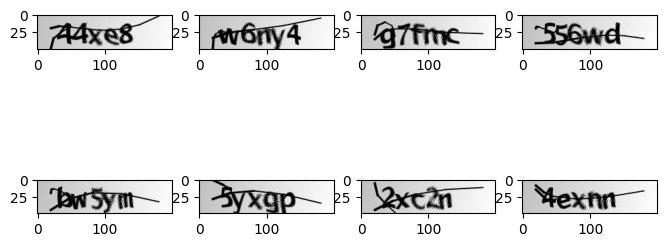

Epoch #11:   0%|          | 0/47 [00:00<?, ?it/s]

Train Epoch 11 | Mean batch loss: 3.2749224114925304 | Mean CER: 1.0


Epoch #11:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 11 | Mean batch loss: 3.2589967250823975 | Mean CER: 1.0


Epoch #12:   0%|          | 0/47 [00:00<?, ?it/s]

Train Epoch 12 | Mean batch loss: 3.2742159772426525 | Mean CER: 1.0


Epoch #12:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 12 | Mean batch loss: 3.26176013597628 | Mean CER: 1.0


Epoch #13:   0%|          | 0/47 [00:00<?, ?it/s]

Train Epoch 13 | Mean batch loss: 3.27151254897422 | Mean CER: 1.0


Epoch #13:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 13 | Mean batch loss: 3.2594217265524517 | Mean CER: 1.0


Epoch #14:   0%|          | 0/47 [00:00<?, ?it/s]

Train Epoch 14 | Mean batch loss: 3.2636356201577694 | Mean CER: 1.0


Epoch #14:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 14 | Mean batch loss: 3.240153417354677 | Mean CER: 1.0


Epoch #15:   0%|          | 0/47 [00:00<?, ?it/s]

Train Epoch 15 | Mean batch loss: 3.1476778831887753 | Mean CER: 1.0


Epoch #15:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 15 | Mean batch loss: 3.003578226740767 | Mean CER: 1.0


Epoch #16:   0%|          | 0/47 [00:00<?, ?it/s]

Train Epoch 16 | Mean batch loss: 2.9139799158623876 | Mean CER: 1.0


Epoch #16:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 16 | Mean batch loss: 2.7290347494730134 | Mean CER: 1.0


Epoch #17:   0%|          | 0/47 [00:00<?, ?it/s]

Train Epoch 17 | Mean batch loss: 2.5160046942690584 | Mean CER: 0.9954992532730103


Epoch #17:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 17 | Mean batch loss: 2.2208782172784574 | Mean CER: 0.8792681694030762


Epoch #18:   0%|          | 0/47 [00:00<?, ?it/s]

Train Epoch 18 | Mean batch loss: 2.024990880742986 | Mean CER: 0.8720541000366211


Epoch #18:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 18 | Mean batch loss: 1.7721318878778598 | Mean CER: 0.8146342039108276


Epoch #19:   0%|          | 0/47 [00:00<?, ?it/s]

Train Epoch 19 | Mean batch loss: 1.6376458381084686 | Mean CER: 0.6821398735046387


Epoch #19:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 19 | Mean batch loss: 1.405378652781975 | Mean CER: 0.5042684078216553


Epoch #20:   0%|          | 0/47 [00:00<?, ?it/s]

Train Epoch 20 | Mean batch loss: 1.3791541292312297 | Mean CER: 0.5479746460914612


Epoch #20:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 20 | Mean batch loss: 1.2116514153596831 | Mean CER: 0.48353657126426697


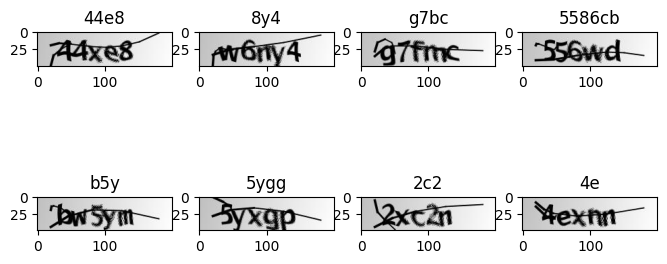

Epoch #21:   0%|          | 0/47 [00:00<?, ?it/s]

Train Epoch 21 | Mean batch loss: 1.1873794768718964 | Mean CER: 0.4893820881843567


Epoch #21:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 21 | Mean batch loss: 1.030178394259476 | Mean CER: 0.45060980319976807


Epoch #22:   0%|          | 0/47 [00:00<?, ?it/s]

Train Epoch 22 | Mean batch loss: 1.0422988128154835 | Mean CER: 0.4572216868400574


Epoch #22:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 22 | Mean batch loss: 0.927761204359008 | Mean CER: 0.4292682409286499


Epoch #23:   0%|          | 0/47 [00:00<?, ?it/s]

Train Epoch 23 | Mean batch loss: 0.938780684420403 | Mean CER: 0.42395660281181335


Epoch #23:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 23 | Mean batch loss: 0.8545297616865577 | Mean CER: 0.39268288016319275


Epoch #24:   0%|          | 0/47 [00:00<?, ?it/s]

Train Epoch 24 | Mean batch loss: 0.8425217296214814 | Mean CER: 0.37283143401145935


Epoch #24:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 24 | Mean batch loss: 0.753203099820672 | Mean CER: 0.30548781156539917


Epoch #25:   0%|          | 0/47 [00:00<?, ?it/s]

Train Epoch 25 | Mean batch loss: 0.7195147770516416 | Mean CER: 0.2944762706756592


Epoch #25:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 25 | Mean batch loss: 0.5995409568635429 | Mean CER: 0.22682927548885345


Epoch #26:   0%|          | 0/47 [00:00<?, ?it/s]

Train Epoch 26 | Mean batch loss: 0.6340444620619429 | Mean CER: 0.24731996655464172


Epoch #26:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 26 | Mean batch loss: 0.5759114572187749 | Mean CER: 0.1993902325630188


Epoch #27:   0%|          | 0/47 [00:00<?, ?it/s]

Train Epoch 27 | Mean batch loss: 0.5675872057042224 | Mean CER: 0.21655072271823883


Epoch #27:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 27 | Mean batch loss: 0.4787548467880342 | Mean CER: 0.17439024150371552


Epoch #28:   0%|          | 0/47 [00:00<?, ?it/s]

Train Epoch 28 | Mean batch loss: 0.48060287376667593 | Mean CER: 0.1814648061990738


Epoch #28:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 28 | Mean batch loss: 0.4324712549767843 | Mean CER: 0.1463414579629898


Epoch #29:   0%|          | 0/47 [00:00<?, ?it/s]

Train Epoch 29 | Mean batch loss: 0.44123162424310725 | Mean CER: 0.16270457208156586


Epoch #29:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 29 | Mean batch loss: 0.39044891915670255 | Mean CER: 0.13780488073825836


Epoch #30:   0%|          | 0/47 [00:00<?, ?it/s]

Train Epoch 30 | Mean batch loss: 0.3860035481605124 | Mean CER: 0.14437396824359894


Epoch #30:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 30 | Mean batch loss: 0.34099072944827197 | Mean CER: 0.11646341532468796


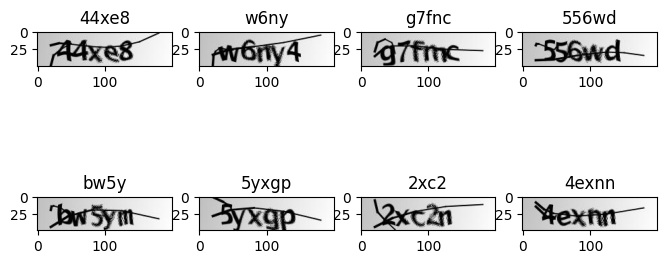

Epoch #31:   0%|          | 0/47 [00:00<?, ?it/s]

Train Epoch 31 | Mean batch loss: 0.3601783514022827 | Mean CER: 0.13807284832000732


Epoch #31:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 31 | Mean batch loss: 0.3183922240646874 | Mean CER: 0.10853657871484756


Epoch #32:   0%|          | 0/47 [00:00<?, ?it/s]

Train Epoch 32 | Mean batch loss: 0.3238703231228159 | Mean CER: 0.12716861069202423


Epoch #32:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 32 | Mean batch loss: 0.2890024077964992 | Mean CER: 0.10304878652095795


Epoch #33:   0%|          | 0/47 [00:00<?, ?it/s]

Train Epoch 33 | Mean batch loss: 0.3039498877652148 | Mean CER: 0.11520048975944519


Epoch #33:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 33 | Mean batch loss: 0.3020441094186248 | Mean CER: 0.10426828265190125


Epoch #34:   0%|          | 0/47 [00:00<?, ?it/s]

Train Epoch 34 | Mean batch loss: 0.31036118941104157 | Mean CER: 0.1202332079410553


Epoch #34:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 34 | Mean batch loss: 0.26417949141525643 | Mean CER: 0.09146341681480408


Epoch #35:   0%|          | 0/47 [00:00<?, ?it/s]

Train Epoch 35 | Mean batch loss: 0.284775658173764 | Mean CER: 0.10642388463020325


Epoch #35:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 35 | Mean batch loss: 0.2892771595861854 | Mean CER: 0.1012195274233818


Epoch #36:   0%|          | 0/47 [00:00<?, ?it/s]

Train Epoch 36 | Mean batch loss: 0.26430779885738453 | Mean CER: 0.09889524430036545


Epoch #36:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 36 | Mean batch loss: 0.2572101370953932 | Mean CER: 0.09207317233085632


Epoch #37:   0%|          | 0/47 [00:00<?, ?it/s]

Train Epoch 37 | Mean batch loss: 0.2442367948750232 | Mean CER: 0.09451717883348465


Epoch #37:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 37 | Mean batch loss: 0.2580382367823182 | Mean CER: 0.08597560971975327


Epoch #38:   0%|          | 0/47 [00:00<?, ?it/s]

Train Epoch 38 | Mean batch loss: 0.23131922267852945 | Mean CER: 0.08821605145931244


Epoch #38:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 38 | Mean batch loss: 0.2449805160484663 | Mean CER: 0.08170732855796814


Epoch #39:   0%|          | 0/47 [00:00<?, ?it/s]

Train Epoch 39 | Mean batch loss: 0.23188069811526765 | Mean CER: 0.0894639864563942


Epoch #39:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 39 | Mean batch loss: 0.2525399896974971 | Mean CER: 0.08780486136674881


Epoch #40:   0%|          | 0/47 [00:00<?, ?it/s]

Train Epoch 40 | Mean batch loss: 0.21663720461916416 | Mean CER: 0.0832856073975563


Epoch #40:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 40 | Mean batch loss: 0.23398438205079333 | Mean CER: 0.0798780545592308


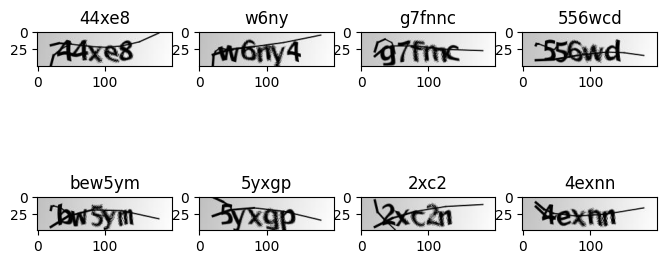

Epoch #41:   0%|          | 0/47 [00:00<?, ?it/s]

Train Epoch 41 | Mean batch loss: 0.21490203129484298 | Mean CER: 0.08267185091972351


Epoch #41:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 41 | Mean batch loss: 0.22526271300526654 | Mean CER: 0.07743901759386063


Epoch #42:   0%|          | 0/47 [00:00<?, ?it/s]

Train Epoch 42 | Mean batch loss: 0.19627531808107457 | Mean CER: 0.07651390135288239


Epoch #42:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 42 | Mean batch loss: 0.2227035694551177 | Mean CER: 0.07621950656175613


Epoch #43:   0%|          | 0/47 [00:00<?, ?it/s]

Train Epoch 43 | Mean batch loss: 0.19237227119663927 | Mean CER: 0.0703764334321022


Epoch #43:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 43 | Mean batch loss: 0.2626290808363659 | Mean CER: 0.08780487626791


Epoch #44:   0%|          | 0/47 [00:00<?, ?it/s]

Train Epoch 44 | Mean batch loss: 0.1854374554563076 | Mean CER: 0.06939443200826645


Epoch #44:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 44 | Mean batch loss: 0.2067550517982099 | Mean CER: 0.0743902400135994


Epoch #45:   0%|          | 0/47 [00:00<?, ?it/s]

Train Epoch 45 | Mean batch loss: 0.16982836165326706 | Mean CER: 0.06421849876642227


Epoch #45:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 45 | Mean batch loss: 0.20752410109086736 | Mean CER: 0.07560975849628448


Epoch #46:   0%|          | 0/47 [00:00<?, ?it/s]

Train Epoch 46 | Mean batch loss: 0.18724927559812019 | Mean CER: 0.06959901005029678


Epoch #46:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 46 | Mean batch loss: 0.19736918443586768 | Mean CER: 0.06768292933702469


Epoch #47:   0%|          | 0/47 [00:00<?, ?it/s]

Train Epoch 47 | Mean batch loss: 0.1847827987785035 | Mean CER: 0.0718698799610138


Epoch #47:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 47 | Mean batch loss: 0.1993646795248113 | Mean CER: 0.06219511479139328


Epoch #48:   0%|          | 0/47 [00:00<?, ?it/s]

Train Epoch 48 | Mean batch loss: 0.1812502848816679 | Mean CER: 0.07131750881671906


Epoch #48:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 48 | Mean batch loss: 0.19280986869480551 | Mean CER: 0.06890243291854858


Epoch #49:   0%|          | 0/47 [00:00<?, ?it/s]

Train Epoch 49 | Mean batch loss: 0.16367852798801788 | Mean CER: 0.05922667682170868


Epoch #49:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 49 | Mean batch loss: 0.18479798166308462 | Mean CER: 0.0652439147233963


Epoch #50:   0%|          | 0/47 [00:00<?, ?it/s]

Train Epoch 50 | Mean batch loss: 0.1721473591441804 | Mean CER: 0.06507772952318192


Epoch #50:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 50 | Mean batch loss: 0.227137997428455 | Mean CER: 0.07012196630239487


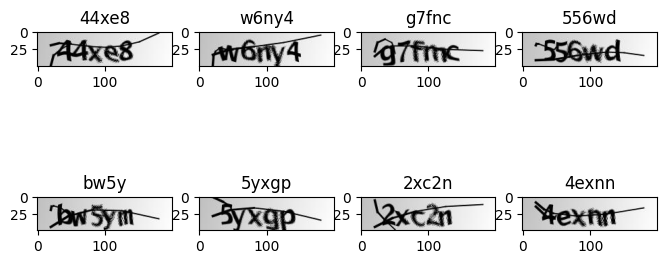

In [ ]:
model = CaptchaModel(id_to_ch)
optim = Adam(model.parameters(), lr=1e-3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

train_loss, test_loss = train(
    model,
    optim,
    device,
    train_loader,
    test_loader,
    epochs=50,
    clip_grad=clip,
)

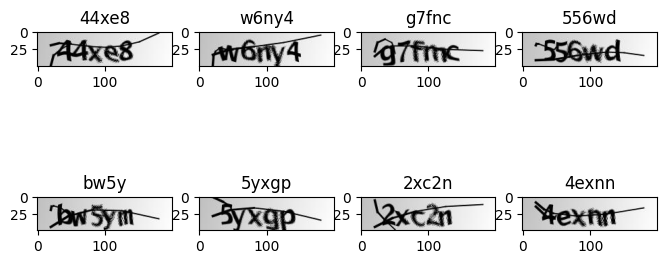

Epoch #1:   0%|          | 0/47 [00:00<?, ?it/s]

Train Epoch 1 | Mean batch loss: 0.14646559383006805 | Mean CER: 0.05257774516940117


Epoch #1:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 1 | Mean batch loss: 0.19145235619167003 | Mean CER: 0.06585366278886795


Epoch #2:   0%|          | 0/47 [00:00<?, ?it/s]

Train Epoch 2 | Mean batch loss: 0.13558611020128777 | Mean CER: 0.04912028834223747


Epoch #2:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 2 | Mean batch loss: 0.19102650272046648 | Mean CER: 0.06036585569381714


Epoch #3:   0%|          | 0/47 [00:00<?, ?it/s]

Train Epoch 3 | Mean batch loss: 0.13151468336582184 | Mean CER: 0.049508992582559586


Epoch #3:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 3 | Mean batch loss: 0.18844691173332492 | Mean CER: 0.059146344661712646


Epoch #4:   0%|          | 0/47 [00:00<?, ?it/s]

Train Epoch 4 | Mean batch loss: 0.1196993850964181 | Mean CER: 0.043801143765449524


Epoch #4:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 4 | Mean batch loss: 0.18835872043741914 | Mean CER: 0.07012194395065308


Epoch #5:   0%|          | 0/47 [00:00<?, ?it/s]

Train Epoch 5 | Mean batch loss: 0.12352152263864558 | Mean CER: 0.049263495951890945


Epoch #5:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 5 | Mean batch loss: 0.184463595835174 | Mean CER: 0.05609755963087082


Epoch #6:   0%|          | 0/47 [00:00<?, ?it/s]

Train Epoch 6 | Mean batch loss: 0.1269235595109615 | Mean CER: 0.04811784625053406


Epoch #6:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 6 | Mean batch loss: 0.1837446130812168 | Mean CER: 0.06097561493515968


Epoch #7:   0%|          | 0/47 [00:00<?, ?it/s]

Train Epoch 7 | Mean batch loss: 0.12966528693412213 | Mean CER: 0.05051145702600479


Epoch #7:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 7 | Mean batch loss: 0.1892387134182017 | Mean CER: 0.05670731142163277


Epoch #8:   0%|          | 0/47 [00:00<?, ?it/s]

Train Epoch 8 | Mean batch loss: 0.11716898308789477 | Mean CER: 0.04666529968380928


Epoch #8:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 8 | Mean batch loss: 0.19102869977856554 | Mean CER: 0.06158536300063133


Epoch #9:   0%|          | 0/47 [00:00<?, ?it/s]

Train Epoch 9 | Mean batch loss: 0.11736088182697905 | Mean CER: 0.04306464642286301


Epoch #9:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 9 | Mean batch loss: 0.20862816083358554 | Mean CER: 0.06768292933702469


Epoch #10:   0%|          | 0/47 [00:00<?, ?it/s]

Train Epoch 10 | Mean batch loss: 0.11241477529736275 | Mean CER: 0.04220539703965187


Epoch #10:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 10 | Mean batch loss: 0.20834250003099442 | Mean CER: 0.06463415920734406


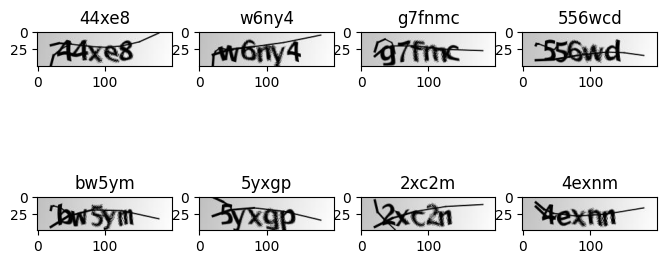

Epoch #11:   0%|          | 0/47 [00:00<?, ?it/s]

Train Epoch 11 | Mean batch loss: 0.1140316924516191 | Mean CER: 0.041612111032009125


Epoch #11:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 11 | Mean batch loss: 0.2141699378219683 | Mean CER: 0.06097561493515968


Epoch #12:   0%|          | 0/47 [00:00<?, ?it/s]

Train Epoch 12 | Mean batch loss: 0.1126113568848752 | Mean CER: 0.03895253688097


Epoch #12:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 12 | Mean batch loss: 0.20024536684064603 | Mean CER: 0.05975610017776489


Epoch #13:   0%|          | 0/47 [00:00<?, ?it/s]

Train Epoch 13 | Mean batch loss: 0.10876759609326403 | Mean CER: 0.040486909449100494


Epoch #13:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 13 | Mean batch loss: 0.2607954092687223 | Mean CER: 0.07378048449754715


Epoch #14:   0%|          | 0/47 [00:00<?, ?it/s]

Train Epoch 14 | Mean batch loss: 0.10089300568909088 | Mean CER: 0.03537233918905258


Epoch #14:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 14 | Mean batch loss: 0.19890387853743827 | Mean CER: 0.05426828935742378


Epoch #15:   0%|          | 0/47 [00:00<?, ?it/s]

Train Epoch 15 | Mean batch loss: 0.11163438729783322 | Mean CER: 0.0433306023478508


Epoch #15:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 15 | Mean batch loss: 0.2076793138800961 | Mean CER: 0.0664634183049202


Epoch #16:   0%|          | 0/47 [00:00<?, ?it/s]

Train Epoch 16 | Mean batch loss: 0.10772125557699103 | Mean CER: 0.04095745086669922


Epoch #16:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 16 | Mean batch loss: 0.2034296633721125 | Mean CER: 0.06341464072465897


Epoch #17:   0%|          | 0/47 [00:00<?, ?it/s]

Train Epoch 17 | Mean batch loss: 0.09781504208420186 | Mean CER: 0.03537233546376228


Epoch #17:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 17 | Mean batch loss: 0.18591396592375709 | Mean CER: 0.05670731142163277


Epoch #18:   0%|          | 0/47 [00:00<?, ?it/s]

Train Epoch 18 | Mean batch loss: 0.11078055325816287 | Mean CER: 0.0417553186416626


Epoch #18:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 18 | Mean batch loss: 0.1873549109824547 | Mean CER: 0.053658537566661835


Epoch #19:   0%|          | 0/47 [00:00<?, ?it/s]

Train Epoch 19 | Mean batch loss: 0.11365527017636502 | Mean CER: 0.04255319759249687


Epoch #19:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 19 | Mean batch loss: 0.21063226013921382 | Mean CER: 0.06036585196852684


Epoch #20:   0%|          | 0/47 [00:00<?, ?it/s]

Train Epoch 20 | Mean batch loss: 0.10131613224586274 | Mean CER: 0.03522913157939911


Epoch #20:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 20 | Mean batch loss: 0.20240543069454228 | Mean CER: 0.0585365891456604


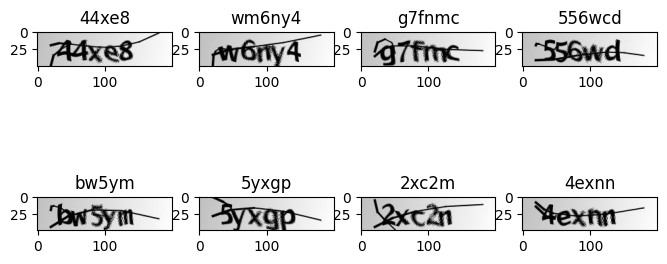

Epoch #21:   0%|          | 0/47 [00:00<?, ?it/s]

Train Epoch 21 | Mean batch loss: 0.09373150425071412 | Mean CER: 0.03375614061951637


Epoch #21:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 21 | Mean batch loss: 0.22951096119131983 | Mean CER: 0.06585366278886795


Epoch #22:   0%|          | 0/47 [00:00<?, ?it/s]

Train Epoch 22 | Mean batch loss: 0.09405654722309494 | Mean CER: 0.03410392627120018


Epoch #22:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 22 | Mean batch loss: 0.21535032883104754 | Mean CER: 0.06280487775802612


Epoch #23:   0%|          | 0/47 [00:00<?, ?it/s]

Train Epoch 23 | Mean batch loss: 0.09215970741624528 | Mean CER: 0.03416530042886734


Epoch #23:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 23 | Mean batch loss: 0.19790170739245852 | Mean CER: 0.055487800389528275


Epoch #24:   0%|          | 0/47 [00:00<?, ?it/s]

Train Epoch 24 | Mean batch loss: 0.0876943385822976 | Mean CER: 0.036231592297554016


Epoch #24:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 24 | Mean batch loss: 0.2133768459373131 | Mean CER: 0.06280487030744553


Epoch #25:   0%|          | 0/47 [00:00<?, ?it/s]

Train Epoch 25 | Mean batch loss: 0.09415141964687947 | Mean CER: 0.03662029653787613


Epoch #25:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 25 | Mean batch loss: 0.21603846605639995 | Mean CER: 0.06341464072465897


Epoch #26:   0%|          | 0/47 [00:00<?, ?it/s]

Train Epoch 26 | Mean batch loss: 0.0896584625019038 | Mean CER: 0.03209901973605156


Epoch #26:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 26 | Mean batch loss: 0.24802500867034968 | Mean CER: 0.0731707289814949


Epoch #27:   0%|          | 0/47 [00:00<?, ?it/s]

Train Epoch 27 | Mean batch loss: 0.08637422065627068 | Mean CER: 0.03475859388709068


Epoch #27:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 27 | Mean batch loss: 0.23511307134588316 | Mean CER: 0.05975610017776489


Epoch #28:   0%|          | 0/47 [00:00<?, ?it/s]

Train Epoch 28 | Mean batch loss: 0.0829253114284353 | Mean CER: 0.031117018312215805


Epoch #28:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 28 | Mean batch loss: 0.2507144406710456 | Mean CER: 0.0664634183049202


Epoch #29:   0%|          | 0/47 [00:00<?, ?it/s]

Train Epoch 29 | Mean batch loss: 0.085704792132403 | Mean CER: 0.031689856201410294


Epoch #29:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 29 | Mean batch loss: 0.23121918243833067 | Mean CER: 0.06036585196852684


Epoch #30:   0%|          | 0/47 [00:00<?, ?it/s]

Train Epoch 30 | Mean batch loss: 0.08778342347037285 | Mean CER: 0.032242223620414734


Epoch #30:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 30 | Mean batch loss: 0.2523861001472829 | Mean CER: 0.062195125967264175


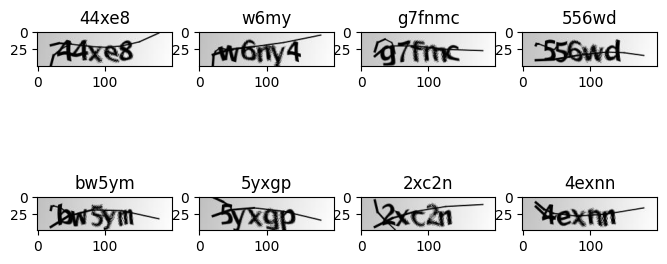

Epoch #31:   0%|          | 0/47 [00:00<?, ?it/s]

Train Epoch 31 | Mean batch loss: 0.09039138792518606 | Mean CER: 0.032508183270692825


Epoch #31:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 31 | Mean batch loss: 0.23508067424522666 | Mean CER: 0.06097561493515968


Epoch #32:   0%|          | 0/47 [00:00<?, ?it/s]

Train Epoch 32 | Mean batch loss: 0.08585285734226729 | Mean CER: 0.0285801962018013


Epoch #32:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 32 | Mean batch loss: 0.25429665426746373 | Mean CER: 0.06402438133955002


Epoch #33:   0%|          | 0/47 [00:00<?, ?it/s]

Train Epoch 33 | Mean batch loss: 0.08393713859643073 | Mean CER: 0.02845744974911213


Epoch #33:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 33 | Mean batch loss: 0.3009294770521725 | Mean CER: 0.07256097346544266


Epoch #34:   0%|          | 0/47 [00:00<?, ?it/s]

Train Epoch 34 | Mean batch loss: 0.07972912676632404 | Mean CER: 0.032508186995983124


Epoch #34:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 34 | Mean batch loss: 0.279910795027163 | Mean CER: 0.07926829904317856


Epoch #35:   0%|          | 0/47 [00:00<?, ?it/s]

Train Epoch 35 | Mean batch loss: 0.08376353812661577 | Mean CER: 0.0282528605312109


Epoch #35:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 35 | Mean batch loss: 0.2659526543873476 | Mean CER: 0.0652439147233963


Epoch #36:   0%|          | 0/47 [00:00<?, ?it/s]

Train Epoch 36 | Mean batch loss: 0.07444591059329662 | Mean CER: 0.027925532311201096


Epoch #36:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 36 | Mean batch loss: 0.2669007635970668 | Mean CER: 0.06341463327407837


Epoch #37:   0%|          | 0/47 [00:00<?, ?it/s]

Train Epoch 37 | Mean batch loss: 0.08003997129011661 | Mean CER: 0.030441900715231895


Epoch #37:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 37 | Mean batch loss: 0.2221463469038831 | Mean CER: 0.05914633348584175


Epoch #38:   0%|          | 0/47 [00:00<?, ?it/s]

Train Epoch 38 | Mean batch loss: 0.06945183532352144 | Mean CER: 0.023322420194745064


Epoch #38:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 38 | Mean batch loss: 0.25876183044619677 | Mean CER: 0.06463414430618286


Epoch #39:   0%|          | 0/47 [00:00<?, ?it/s]

Train Epoch 39 | Mean batch loss: 0.06852942512945291 | Mean CER: 0.024529457092285156


Epoch #39:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 39 | Mean batch loss: 0.2744315247755589 | Mean CER: 0.07195122539997101


Epoch #40:   0%|          | 0/47 [00:00<?, ?it/s]

Train Epoch 40 | Mean batch loss: 0.06305587309551366 | Mean CER: 0.02266775630414486


Epoch #40:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 40 | Mean batch loss: 0.28623092928674165 | Mean CER: 0.0731707289814949


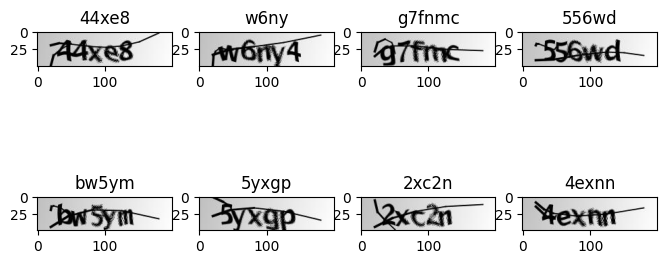

Epoch #41:   0%|          | 0/47 [00:00<?, ?it/s]

Train Epoch 41 | Mean batch loss: 0.07843769012772023 | Mean CER: 0.02745499461889267


Epoch #41:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 41 | Mean batch loss: 0.27215148111033005 | Mean CER: 0.06463415175676346


Epoch #42:   0%|          | 0/47 [00:00<?, ?it/s]

Train Epoch 42 | Mean batch loss: 0.08067856098901718 | Mean CER: 0.028375612571835518


Epoch #42:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 42 | Mean batch loss: 0.29203479702970603 | Mean CER: 0.0810975655913353


Epoch #43:   0%|          | 0/47 [00:00<?, ?it/s]

Train Epoch 43 | Mean batch loss: 0.06806775079445636 | Mean CER: 0.02299508824944496


Epoch #43:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 43 | Mean batch loss: 0.26658190007707694 | Mean CER: 0.06463415175676346


Epoch #44:   0%|          | 0/47 [00:00<?, ?it/s]

Train Epoch 44 | Mean batch loss: 0.06636291911746277 | Mean CER: 0.022074468433856964


Epoch #44:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 44 | Mean batch loss: 0.25697544432903935 | Mean CER: 0.06402438133955002


Epoch #45:   0%|          | 0/47 [00:00<?, ?it/s]

Train Epoch 45 | Mean batch loss: 0.07474061718923931 | Mean CER: 0.02712765894830227


Epoch #45:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 45 | Mean batch loss: 0.2463326727653422 | Mean CER: 0.05548781156539917


Epoch #46:   0%|          | 0/47 [00:00<?, ?it/s]

Train Epoch 46 | Mean batch loss: 0.06633745857137949 | Mean CER: 0.024529458954930305


Epoch #46:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 46 | Mean batch loss: 0.2729149666137812 | Mean CER: 0.07012195885181427


Epoch #47:   0%|          | 0/47 [00:00<?, ?it/s]

Train Epoch 47 | Mean batch loss: 0.07305379246579523 | Mean CER: 0.026984451338648796


Epoch #47:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 47 | Mean batch loss: 0.3045627032747356 | Mean CER: 0.06951218843460083


Epoch #48:   0%|          | 0/47 [00:00<?, ?it/s]

Train Epoch 48 | Mean batch loss: 0.06743559229405637 | Mean CER: 0.021869882941246033


Epoch #48:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 48 | Mean batch loss: 0.26607217285327794 | Mean CER: 0.07012193650007248


Epoch #49:   0%|          | 0/47 [00:00<?, ?it/s]

Train Epoch 49 | Mean batch loss: 0.07042661255740738 | Mean CER: 0.024529462680220604


Epoch #49:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 49 | Mean batch loss: 0.2566159540423896 | Mean CER: 0.06402438879013062


Epoch #50:   0%|          | 0/47 [00:00<?, ?it/s]

Train Epoch 50 | Mean batch loss: 0.06477047754649787 | Mean CER: 0.023936167359352112


Epoch #50:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 50 | Mean batch loss: 0.24351792015907606 | Mean CER: 0.055487800389528275


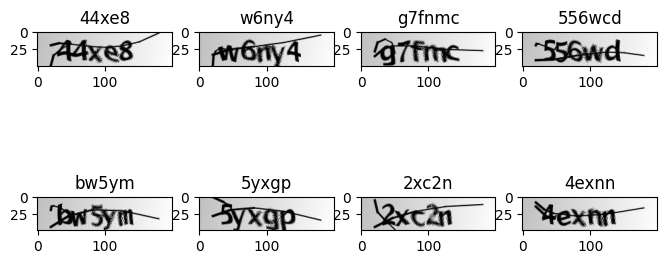

In [ ]:
optim = Adam(model.parameters(), lr=5e-4)

train_loss, test_loss = train(
    model,
    optim,
    device,
    train_loader,
    test_loader,
    epochs=50,
    clip_grad=clip,
)

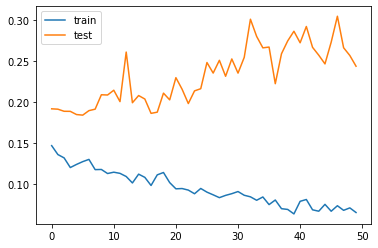

In [ ]:
plt.plot(train_loss, label='train')
plt.plot(test_loss, label='test')
plt.legend()
plt.show()

Ну вышло, что на текущих данных эта модель обучается за 50 эпох при $lr=10^{-3}$. Без уменьшения lr или изменения данных обучение дальше не идёт. При уменьшении lr до $5 \cdot 10^{-4}$ видно что модель почти сразу переобучилась к train. 

Финальную модель обучим на всех данных в течении 50-70 эпох.

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


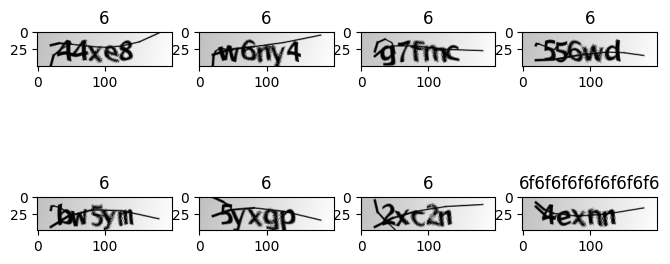

Epoch #1:   0%|          | 0/67 [00:00<?, ?it/s]

Train Epoch 1 | Mean batch loss: 5.446892628029211 | Mean CER: 1.004104495048523


Epoch #1:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 1 | Mean batch loss: 3.3038385961113907 | Mean CER: 1.0


Epoch #2:   0%|          | 0/67 [00:00<?, ?it/s]

Train Epoch 2 | Mean batch loss: 3.2825823257218545 | Mean CER: 1.0


Epoch #2:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 2 | Mean batch loss: 3.2622504873973566 | Mean CER: 1.0


Epoch #3:   0%|          | 0/67 [00:00<?, ?it/s]

Train Epoch 3 | Mean batch loss: 3.2722736863947626 | Mean CER: 1.0


Epoch #3:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 3 | Mean batch loss: 3.257142218147836 | Mean CER: 1.0


Epoch #4:   0%|          | 0/67 [00:00<?, ?it/s]

Train Epoch 4 | Mean batch loss: 3.2701883173700588 | Mean CER: 1.0


Epoch #4:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 4 | Mean batch loss: 3.258255679432939 | Mean CER: 1.0


Epoch #5:   0%|          | 0/67 [00:00<?, ?it/s]

Train Epoch 5 | Mean batch loss: 3.2692490015456928 | Mean CER: 1.0


Epoch #5:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 5 | Mean batch loss: 3.2586139644064556 | Mean CER: 1.0


Epoch #6:   0%|          | 0/67 [00:00<?, ?it/s]

Train Epoch 6 | Mean batch loss: 3.2685740136388524 | Mean CER: 1.0


Epoch #6:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 6 | Mean batch loss: 3.25903761096117 | Mean CER: 1.0


Epoch #7:   0%|          | 0/67 [00:00<?, ?it/s]

Train Epoch 7 | Mean batch loss: 3.268064036298154 | Mean CER: 1.0


Epoch #7:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 7 | Mean batch loss: 3.2596824576215044 | Mean CER: 1.0


Epoch #8:   0%|          | 0/67 [00:00<?, ?it/s]

Train Epoch 8 | Mean batch loss: 3.2674143954889097 | Mean CER: 1.0


Epoch #8:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 8 | Mean batch loss: 3.2593455605390593 | Mean CER: 1.0


Epoch #9:   0%|          | 0/67 [00:00<?, ?it/s]

Train Epoch 9 | Mean batch loss: 3.2612533569335938 | Mean CER: 1.0


Epoch #9:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 9 | Mean batch loss: 3.2226491439633254 | Mean CER: 1.0


Epoch #10:   0%|          | 0/67 [00:00<?, ?it/s]

Train Epoch 10 | Mean batch loss: 3.036383543441545 | Mean CER: 1.0


Epoch #10:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 10 | Mean batch loss: 2.801804879816567 | Mean CER: 1.0


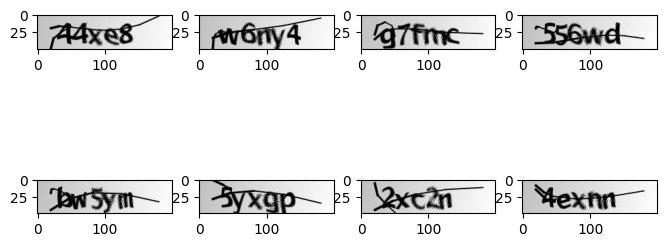

Epoch #11:   0%|          | 0/67 [00:00<?, ?it/s]

Train Epoch 11 | Mean batch loss: 2.6867918398842883 | Mean CER: 0.9599413275718689


Epoch #11:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 11 | Mean batch loss: 2.481782581748032 | Mean CER: 0.9493902325630188


Epoch #12:   0%|          | 0/67 [00:00<?, ?it/s]

Train Epoch 12 | Mean batch loss: 2.332483312976894 | Mean CER: 0.8787046670913696


Epoch #12:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 12 | Mean batch loss: 1.9986234903335571 | Mean CER: 0.8115854263305664


Epoch #13:   0%|          | 0/67 [00:00<?, ?it/s]

Train Epoch 13 | Mean batch loss: 1.875977428991403 | Mean CER: 0.7264924049377441


Epoch #13:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 13 | Mean batch loss: 1.5316155567401792 | Mean CER: 0.6268293261528015


Epoch #14:   0%|          | 0/67 [00:00<?, ?it/s]

Train Epoch 14 | Mean batch loss: 1.4764080705927378 | Mean CER: 0.5854744911193848


Epoch #14:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 14 | Mean batch loss: 1.2056576565998356 | Mean CER: 0.4652438759803772


Epoch #15:   0%|          | 0/67 [00:00<?, ?it/s]

Train Epoch 15 | Mean batch loss: 1.2021359240830833 | Mean CER: 0.4828623831272125


Epoch #15:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 15 | Mean batch loss: 0.9857026193200088 | Mean CER: 0.3853658437728882


Epoch #16:   0%|          | 0/67 [00:00<?, ?it/s]

Train Epoch 16 | Mean batch loss: 0.9710776325482041 | Mean CER: 0.36449894309043884


Epoch #16:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 16 | Mean batch loss: 0.779360287073182 | Mean CER: 0.2817072868347168


Epoch #17:   0%|          | 0/67 [00:00<?, ?it/s]

Train Epoch 17 | Mean batch loss: 0.8103654126622784 | Mean CER: 0.298374205827713


Epoch #17:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 17 | Mean batch loss: 0.6623752400642489 | Mean CER: 0.2353658378124237


Epoch #18:   0%|          | 0/67 [00:00<?, ?it/s]

Train Epoch 18 | Mean batch loss: 0.7165593095679781 | Mean CER: 0.26828357577323914


Epoch #18:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 18 | Mean batch loss: 0.5680830922068619 | Mean CER: 0.20670732855796814


Epoch #19:   0%|          | 0/67 [00:00<?, ?it/s]

Train Epoch 19 | Mean batch loss: 0.6293849878346742 | Mean CER: 0.23909913003444672


Epoch #19:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 19 | Mean batch loss: 0.5132941807188639 | Mean CER: 0.17195123434066772


Epoch #20:   0%|          | 0/67 [00:00<?, ?it/s]

Train Epoch 20 | Mean batch loss: 0.5693883775775113 | Mean CER: 0.21401917934417725


Epoch #20:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 20 | Mean batch loss: 0.4445302013943835 | Mean CER: 0.15487805008888245


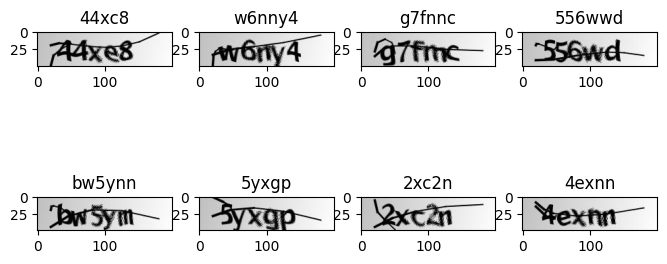

Epoch #21:   0%|          | 0/67 [00:00<?, ?it/s]

Train Epoch 21 | Mean batch loss: 0.527044231767085 | Mean CER: 0.1996268481016159


Epoch #21:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 21 | Mean batch loss: 0.4017080657365846 | Mean CER: 0.14390243589878082


Epoch #22:   0%|          | 0/67 [00:00<?, ?it/s]

Train Epoch 22 | Mean batch loss: 0.4797890444300068 | Mean CER: 0.18648718297481537


Epoch #22:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 22 | Mean batch loss: 0.3728432197396348 | Mean CER: 0.1396341621875763


Epoch #23:   0%|          | 0/67 [00:00<?, ?it/s]

Train Epoch 23 | Mean batch loss: 0.4535328607950638 | Mean CER: 0.17356078326702118


Epoch #23:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 23 | Mean batch loss: 0.3621482830948946 | Mean CER: 0.14390242099761963


Epoch #24:   0%|          | 0/67 [00:00<?, ?it/s]

Train Epoch 24 | Mean batch loss: 0.41419238118983026 | Mean CER: 0.16353942453861237


Epoch #24:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 24 | Mean batch loss: 0.3407655376486662 | Mean CER: 0.1182926818728447


Epoch #25:   0%|          | 0/67 [00:00<?, ?it/s]

Train Epoch 25 | Mean batch loss: 0.4096058649358465 | Mean CER: 0.14834755659103394


Epoch #25:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 25 | Mean batch loss: 0.2956559683491544 | Mean CER: 0.10792684555053711


Epoch #26:   0%|          | 0/67 [00:00<?, ?it/s]

Train Epoch 26 | Mean batch loss: 0.3677529605911739 | Mean CER: 0.13576754927635193


Epoch #26:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 26 | Mean batch loss: 0.290778649834598 | Mean CER: 0.10182927548885345


Epoch #27:   0%|          | 0/67 [00:00<?, ?it/s]

Train Epoch 27 | Mean batch loss: 0.3607903723396472 | Mean CER: 0.13347551226615906


Epoch #27:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 27 | Mean batch loss: 0.3044575158415771 | Mean CER: 0.11341464519500732


Epoch #28:   0%|          | 0/67 [00:00<?, ?it/s]

Train Epoch 28 | Mean batch loss: 0.34666741361368947 | Mean CER: 0.12526653707027435


Epoch #28:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 28 | Mean batch loss: 0.2860472491238175 | Mean CER: 0.10548780113458633


Epoch #29:   0%|          | 0/67 [00:00<?, ?it/s]

Train Epoch 29 | Mean batch loss: 0.3237629454972139 | Mean CER: 0.11817696690559387


Epoch #29:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 29 | Mean batch loss: 0.2718973177962187 | Mean CER: 0.09878048300743103


Epoch #30:   0%|          | 0/67 [00:00<?, ?it/s]

Train Epoch 30 | Mean batch loss: 0.3018965834557121 | Mean CER: 0.11170042306184769


Epoch #30:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 30 | Mean batch loss: 0.23709894698567507 | Mean CER: 0.0823170617222786


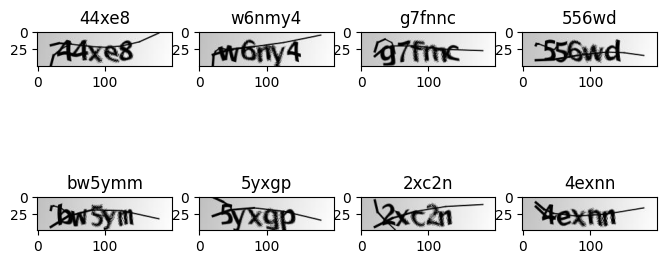

Epoch #31:   0%|          | 0/67 [00:00<?, ?it/s]

Train Epoch 31 | Mean batch loss: 0.2855217267773045 | Mean CER: 0.10373134911060333


Epoch #31:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 31 | Mean batch loss: 0.23829291542855704 | Mean CER: 0.08231707662343979


Epoch #32:   0%|          | 0/67 [00:00<?, ?it/s]

Train Epoch 32 | Mean batch loss: 0.2881709666394476 | Mean CER: 0.10951492935419083


Epoch #32:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 32 | Mean batch loss: 0.22110914484393307 | Mean CER: 0.07560975104570389


Epoch #33:   0%|          | 0/67 [00:00<?, ?it/s]

Train Epoch 33 | Mean batch loss: 0.26536667346954346 | Mean CER: 0.09736140817403793


Epoch #33:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 33 | Mean batch loss: 0.205934630298033 | Mean CER: 0.06890244781970978


Epoch #34:   0%|          | 0/67 [00:00<?, ?it/s]

Train Epoch 34 | Mean batch loss: 0.2574445554124775 | Mean CER: 0.09315034002065659


Epoch #34:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 34 | Mean batch loss: 0.20683277625499702 | Mean CER: 0.07195121794939041


Epoch #35:   0%|          | 0/67 [00:00<?, ?it/s]

Train Epoch 35 | Mean batch loss: 0.2519030226255531 | Mean CER: 0.09208422899246216


Epoch #35:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 35 | Mean batch loss: 0.2193119174278364 | Mean CER: 0.0810975506901741


Epoch #36:   0%|          | 0/67 [00:00<?, ?it/s]

Train Epoch 36 | Mean batch loss: 0.23581179598374152 | Mean CER: 0.08781982958316803


Epoch #36:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 36 | Mean batch loss: 0.1998164603350366 | Mean CER: 0.06829269230365753


Epoch #37:   0%|          | 0/67 [00:00<?, ?it/s]

Train Epoch 37 | Mean batch loss: 0.23626144475011684 | Mean CER: 0.08710021525621414


Epoch #37:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 37 | Mean batch loss: 0.20460218659079657 | Mean CER: 0.07195121794939041


Epoch #38:   0%|          | 0/67 [00:00<?, ?it/s]

Train Epoch 38 | Mean batch loss: 0.22673791268868232 | Mean CER: 0.0822761058807373


Epoch #38:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 38 | Mean batch loss: 0.1842740783240737 | Mean CER: 0.0664634183049202


Epoch #39:   0%|          | 0/67 [00:00<?, ?it/s]

Train Epoch 39 | Mean batch loss: 0.21975376935147528 | Mean CER: 0.080410435795784


Epoch #39:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 39 | Mean batch loss: 0.18154962497150026 | Mean CER: 0.06402438879013062


Epoch #40:   0%|          | 0/67 [00:00<?, ?it/s]

Train Epoch 40 | Mean batch loss: 0.2136579279356928 | Mean CER: 0.07833155244588852


Epoch #40:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 40 | Mean batch loss: 0.19779081824349193 | Mean CER: 0.06951220333576202


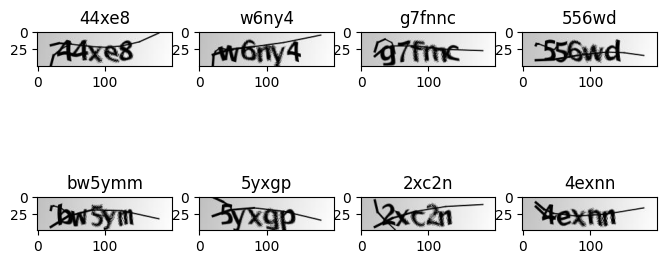

Epoch #41:   0%|          | 0/67 [00:00<?, ?it/s]

Train Epoch 41 | Mean batch loss: 0.21312717537381756 | Mean CER: 0.07865138351917267


Epoch #41:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 41 | Mean batch loss: 0.16704638743000785 | Mean CER: 0.053658537566661835


Epoch #42:   0%|          | 0/67 [00:00<?, ?it/s]

Train Epoch 42 | Mean batch loss: 0.20110217348408344 | Mean CER: 0.0720948651432991


Epoch #42:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 42 | Mean batch loss: 0.16745943689673412 | Mean CER: 0.0585365891456604


Epoch #43:   0%|          | 0/67 [00:00<?, ?it/s]

Train Epoch 43 | Mean batch loss: 0.207692119835028 | Mean CER: 0.07353411614894867


Epoch #43:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 43 | Mean batch loss: 0.15888637195273145 | Mean CER: 0.0585365928709507


Epoch #44:   0%|          | 0/67 [00:00<?, ?it/s]

Train Epoch 44 | Mean batch loss: 0.20341935309011544 | Mean CER: 0.07492004334926605


Epoch #44:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 44 | Mean batch loss: 0.15715136247255454 | Mean CER: 0.05365854501724243


Epoch #45:   0%|          | 0/67 [00:00<?, ?it/s]

Train Epoch 45 | Mean batch loss: 0.1931863779674715 | Mean CER: 0.06860341131687164


Epoch #45:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 45 | Mean batch loss: 0.15710727220810042 | Mean CER: 0.057926833629608154


Epoch #46:   0%|          | 0/67 [00:00<?, ?it/s]

Train Epoch 46 | Mean batch loss: 0.18510609264694042 | Mean CER: 0.06647123396396637


Epoch #46:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 46 | Mean batch loss: 0.1683900975054357 | Mean CER: 0.057926829904317856


Epoch #47:   0%|          | 0/67 [00:00<?, ?it/s]

Train Epoch 47 | Mean batch loss: 0.18068600190219594 | Mean CER: 0.0676439180970192


Epoch #47:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 47 | Mean batch loss: 0.16274410200009987 | Mean CER: 0.056707318872213364


Epoch #48:   0%|          | 0/67 [00:00<?, ?it/s]

Train Epoch 48 | Mean batch loss: 0.17216694060323842 | Mean CER: 0.06183367222547531


Epoch #48:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 48 | Mean batch loss: 0.15028739779642442 | Mean CER: 0.05243903771042824


Epoch #49:   0%|          | 0/67 [00:00<?, ?it/s]

Train Epoch 49 | Mean batch loss: 0.17145997252482087 | Mean CER: 0.06273988634347916


Epoch #49:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 49 | Mean batch loss: 0.14859386592558244 | Mean CER: 0.05426829680800438


Epoch #50:   0%|          | 0/67 [00:00<?, ?it/s]

Train Epoch 50 | Mean batch loss: 0.17107840938799418 | Mean CER: 0.06609808653593063


Epoch #50:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 50 | Mean batch loss: 0.15448283181503053 | Mean CER: 0.05365853011608124


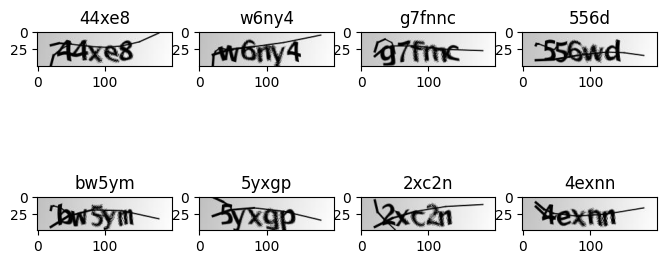

Epoch #51:   0%|          | 0/67 [00:00<?, ?it/s]

Train Epoch 51 | Mean batch loss: 0.17385012100436795 | Mean CER: 0.06204690411686897


Epoch #51:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 51 | Mean batch loss: 0.1578642725944519 | Mean CER: 0.057926833629608154


Epoch #52:   0%|          | 0/67 [00:00<?, ?it/s]

Train Epoch 52 | Mean batch loss: 0.1635756706679935 | Mean CER: 0.059088487178087234


Epoch #52:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 52 | Mean batch loss: 0.16304201164805307 | Mean CER: 0.056097570806741714


Epoch #53:   0%|          | 0/67 [00:00<?, ?it/s]

Train Epoch 53 | Mean batch loss: 0.15962570405273296 | Mean CER: 0.05839553102850914


Epoch #53:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 53 | Mean batch loss: 0.1715864185243845 | Mean CER: 0.060975611209869385


Epoch #54:   0%|          | 0/67 [00:00<?, ?it/s]

Train Epoch 54 | Mean batch loss: 0.1623916942348231 | Mean CER: 0.05959488824009895


Epoch #54:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 54 | Mean batch loss: 0.14001921500738074 | Mean CER: 0.04634145647287369


Epoch #55:   0%|          | 0/67 [00:00<?, ?it/s]

Train Epoch 55 | Mean batch loss: 0.16211101790862298 | Mean CER: 0.05938165262341499


Epoch #55:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 55 | Mean batch loss: 0.15783004708042958 | Mean CER: 0.05670731142163277


Epoch #56:   0%|          | 0/67 [00:00<?, ?it/s]

Train Epoch 56 | Mean batch loss: 0.14954627883523258 | Mean CER: 0.0554637648165226


Epoch #56:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 56 | Mean batch loss: 0.13125591809157192 | Mean CER: 0.04573169723153114


Epoch #57:   0%|          | 0/67 [00:00<?, ?it/s]

Train Epoch 57 | Mean batch loss: 0.1540484887672894 | Mean CER: 0.05530383437871933


Epoch #57:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 57 | Mean batch loss: 0.13513201636421243 | Mean CER: 0.04878047853708267


Epoch #58:   0%|          | 0/67 [00:00<?, ?it/s]

Train Epoch 58 | Mean batch loss: 0.1579615116786601 | Mean CER: 0.05698294937610626


Epoch #58:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 58 | Mean batch loss: 0.1531368923577957 | Mean CER: 0.04999999701976776


Epoch #59:   0%|          | 0/67 [00:00<?, ?it/s]

Train Epoch 59 | Mean batch loss: 0.1496720147777849 | Mean CER: 0.05423774942755699


Epoch #59:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 59 | Mean batch loss: 0.14699285422883382 | Mean CER: 0.05304878577589989


Epoch #60:   0%|          | 0/67 [00:00<?, ?it/s]

Train Epoch 60 | Mean batch loss: 0.1403461031949342 | Mean CER: 0.053624726831912994


Epoch #60:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 60 | Mean batch loss: 0.13901374652618315 | Mean CER: 0.049390241503715515


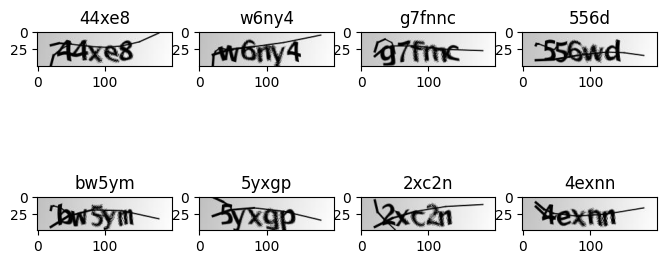

Epoch #61:   0%|          | 0/67 [00:00<?, ?it/s]

Train Epoch 61 | Mean batch loss: 0.145486903446379 | Mean CER: 0.053411513566970825


Epoch #61:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 61 | Mean batch loss: 0.15631638399166306 | Mean CER: 0.057926833629608154


Epoch #62:   0%|          | 0/67 [00:00<?, ?it/s]

Train Epoch 62 | Mean batch loss: 0.12703240440407795 | Mean CER: 0.04880065098404884


Epoch #62:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 62 | Mean batch loss: 0.13294269317170468 | Mean CER: 0.04451218619942665


Epoch #63:   0%|          | 0/67 [00:00<?, ?it/s]

Train Epoch 63 | Mean batch loss: 0.12627494268452943 | Mean CER: 0.049147117882966995


Epoch #63:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 63 | Mean batch loss: 0.15088049874345705 | Mean CER: 0.05609755963087082


Epoch #64:   0%|          | 0/67 [00:00<?, ?it/s]

Train Epoch 64 | Mean batch loss: 0.13299720645395677 | Mean CER: 0.04968017339706421


Epoch #64:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 64 | Mean batch loss: 0.14597786781264516 | Mean CER: 0.0518292672932148


Epoch #65:   0%|          | 0/67 [00:00<?, ?it/s]

Train Epoch 65 | Mean batch loss: 0.13108862992098083 | Mean CER: 0.046721745282411575


Epoch #65:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 65 | Mean batch loss: 0.14835264456526534 | Mean CER: 0.05304877832531929


Epoch #66:   0%|          | 0/67 [00:00<?, ?it/s]

Train Epoch 66 | Mean batch loss: 0.1358567313360634 | Mean CER: 0.05007995665073395


Epoch #66:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 66 | Mean batch loss: 0.1432171140502139 | Mean CER: 0.05487804114818573


Epoch #67:   0%|          | 0/67 [00:00<?, ?it/s]

Train Epoch 67 | Mean batch loss: 0.12075204610713382 | Mean CER: 0.04514925926923752


Epoch #67:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 67 | Mean batch loss: 0.1584821794545505 | Mean CER: 0.05304877460002899


Epoch #68:   0%|          | 0/67 [00:00<?, ?it/s]

Train Epoch 68 | Mean batch loss: 0.12380152757265675 | Mean CER: 0.04520256072282791


Epoch #68:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 68 | Mean batch loss: 0.1445771410561553 | Mean CER: 0.053658537566661835


Epoch #69:   0%|          | 0/67 [00:00<?, ?it/s]

Train Epoch 69 | Mean batch loss: 0.11835500253225441 | Mean CER: 0.0433901883661747


Epoch #69:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 69 | Mean batch loss: 0.15157961700020767 | Mean CER: 0.05121951550245285


Epoch #70:   0%|          | 0/67 [00:00<?, ?it/s]

Train Epoch 70 | Mean batch loss: 0.11304100146934168 | Mean CER: 0.04264393076300621


Epoch #70:   0%|          | 0/41 [00:00<?, ?it/s]

Test Epoch 70 | Mean batch loss: 0.17842951466942705 | Mean CER: 0.06341464072465897


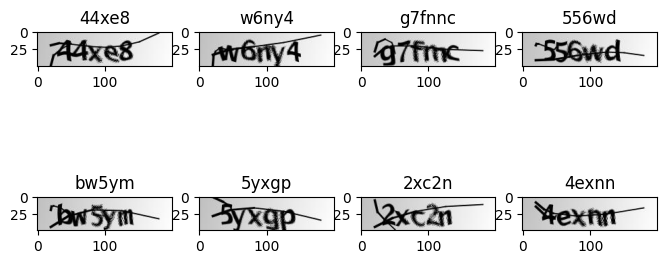

In [ ]:
model = CaptchaModel(id_to_ch)
optim = Adam(model.parameters(), lr=1e-3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

train_loss, test_loss = train(
    model,
    optim,
    device,
    full_loader,
    test_loader,
    epochs=70,
    clip_grad=clip,
)

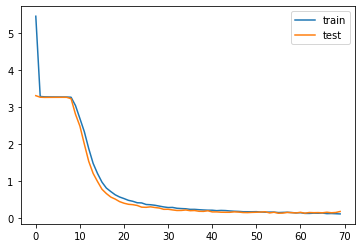

In [ ]:
plt.plot(train_loss, label='train')
plt.plot(test_loss, label='test')
plt.legend()
plt.show()

Ну оно конечно переобучилось. Ну что поделать)


# Model eval

In [ ]:
model.eval()
with torch.no_grad():
    predicted = []
    actual = []

    for batch, codes, labels in tqdm(full_loader):
        img = batch.to(device)
        logprobs = model(img)

        predicted.extend(
            model.decode_out(logprobs)
        )
        actual.extend(labels)

predicted = np.array(predicted)
actual = np.array(actual)


  0%|          | 0/67 [00:00<?, ?it/s]

In [ ]:
prc_w = (predicted == actual).sum() / len(predicted)
print(f"Верно предсказанных слов: {prc_w * 100:.2f}%")

tch = 0
total_ch = 5 * len(actual)
for pw, tw in zip(predicted, actual):
    max_i = min(len(pw), len(tw))
    tch += np.sum(
        np.array(list(pw)[:max_i]) == np.array(list(tw)[:max_i])
    )

prc_ch = tch / total_ch * 100
print(f"Верно предсказанных букв: {prc_ch:.2f}%")


Верно предсказанных слов: 85.14%
Верно предсказанных букв: 96.79%


In [ ]:
torch.save(model.state_dict(), "70ep_full_model")

In [ ]:
score = []
labels = []
model.eval()

for img, _, label in full_dataset:
    img = img.to(device)
    img = torch.unsqueeze(img, 0)
    logprob = model(img)
    score.append(
        char_error_rate(
            model.decode_out(logprob),
            label,
        )
    )
    labels.append(label)

In [ ]:
print("All errors: ", np.unique(score))
score = np.array(score)
labels = np.array(labels)

All errors:  [0.  0.2 0.4 0.6 0.8]


In [ ]:
imgs = []
labels = []
all = []

for img, _, label in full_dataset:
    img = img.to(device)
    img = torch.unsqueeze(img, 0)
    logprob = model(img)
    pred = model.decode_out(logprob)
    score = char_error_rate(
            pred,
            [label],
        )
    if score > 0.4:
        imgs.append(img.squeeze().cpu())
        labels.append(f"{pred[0]}\n{label}:{score:.2f}")
    if score > 0:
        all.append(
            {'true': label, 'pred': pred[0]}
        )

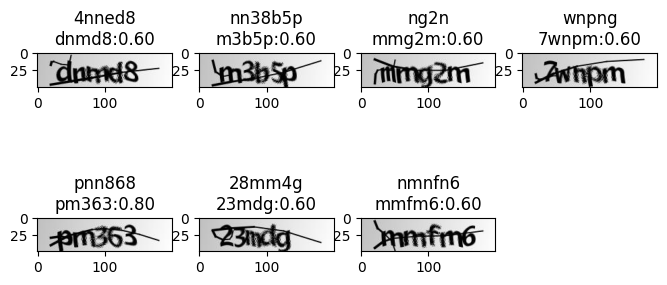

In [ ]:
visualize(imgs, labels)

Для начала глянем по буква где есть несовпадения. Т.е. посмотрим на то, когда предсказания и таргет по длине совпадают и посчитаем статистику.

In [ ]:
from collections import defaultdict

graph = {}

for sample in all:
    t, p = sample['true'], sample['pred']

    if len(t) == len(p):
        for ch_t, ch_p in zip(t, p):
            if ch_t != ch_p:
                if ch_t not in graph:
                    graph[ch_t] = defaultdict(int)
                graph[ch_t][ch_p] += 1

In [ ]:
graph

{'m': defaultdict(int, {'n': 90, 'g': 1, '3': 1}),
 '3': defaultdict(int, {'8': 59}),
 'c': defaultdict(int, {'e': 5}),
 'b': defaultdict(int, {'4': 7}),
 'd': defaultdict(int, {'4': 15, 'b': 1}),
 'f': defaultdict(int, {'b': 1}),
 'n': defaultdict(int, {'m': 6, 'p': 1}),
 '7': defaultdict(int, {'w': 1}),
 'w': defaultdict(int, {'n': 1}),
 'p': defaultdict(int, {'n': 1}),
 'e': defaultdict(int, {'c': 1})}

Такая проблема: очевидно что иногда модель 1 букву предсказывает как несколько разных (vice versa). Для этого попробуем поступить следующим образом: если длины слов не совпадают, то будем заполнять меньшее слово так, чтобы получить одинаковую длину и макимальное совпадение по элементам. Выдумывать не буду алгоритм. Слова короткие, сделаем перебор.

In [ ]:
from itertools import combinations

eqans = []
for sample in all[7:]:

    t = np.array(list(sample['true'])) 
    p = np.array(list(sample['pred']))

    if len(t) > len(p):
        incr = 'pred'
        base = t
        toinc = p
    elif len(p) > len(t):
        incr = 'true'
        base = p
        toinc = t
    else:
        continue

    diff = abs(len(t) - len(p))
    l = len(base)

    ans = []
    max_val = -1

    for inds in combinations(list(range(l)), diff):
        neww = np.array(["" for _ in range(l)])

        for i in inds:
            neww[i] = "-"
        
        ci = 0
        for i in range(l):
            if neww[i] == '-':
                continue
            neww[i] = toinc[ci]
            ci += 1

        if (base == neww).sum() > max_val:
            max_val = (base == neww).sum()
            if incr == 'pred':
                ans = [base, neww]
            else:
                ans = [neww, base]
    
    eqans.append(ans)
    


In [ ]:
eqans

[[array(['m', 'm', '3', 'n', 'n'], dtype='<U1'),
  array(['-', 'm', '3', 'n', 'n'], dtype='<U1')],
 [array(['m', 'p', 'm', 'y', '5'], dtype='<U1'),
  array(['m', 'p', '-', 'y', '5'], dtype='<U1')],
 [array(['b', '-', 'm', '3', 'p', '8'], dtype='<U1'),
  array(['b', 'm', 'm', '3', 'p', '8'], dtype='<U1')],
 [array(['6', 'd', '-', 'm', 'x', '7'], dtype='<U1'),
  array(['6', 'd', 'n', 'm', 'x', '7'], dtype='<U1')],
 [array(['m', 'c', '8', '-', 'w', '2'], dtype='<U1'),
  array(['n', 'c', '8', 'w', 'w', '2'], dtype='<U1')],
 [array(['m', '4', 'f', 'd', '8'], dtype='<U1'),
  array(['-', '4', 'f', 'd', '8'], dtype='<U1')],
 [array(['5', '-', '3', 'm', 'n', '8'], dtype='<U1'),
  array(['5', '8', 'n', 'm', 'n', '8'], dtype='<U1')],
 [array(['w', '-', 'm', '7', '4', '6'], dtype='<U1'),
  array(['w', 'm', 'm', '7', '4', '6'], dtype='<U1')],
 [array(['f', '6', 'n', 'e', '5'], dtype='<U1'),
  array(['f', '6', 'n', '-', '5'], dtype='<U1')],
 [array(['y', 'x', 'd', '7', '-', 'm'], dtype='<U1'),
  arr

# Выводы

Ух, дальше стало откровенно лень писать и придумывать. В общем тенденция видна и так.

1. Модели сложно различать символы, если одна часть символа есть другой символ/часть другого символа:  $(m,n), \ (3,8), \ (c,e), \ (d,4), \ (b,4)$. Важно что порядок в паре имеет смысл было$\rightarrow$предсказано. Потому что в обратном варианте ошибок гораздо меньше (если длины предсказанных слов верные).

2. Сложно воспринимать последовательность букв, которые способны порождать другие буквы и понимать количество таких букв, если они стоят рядом: $n \rightarrow nn; \ nn \rightarrow m; \ w \rightarrow ww; \ ww \rightarrow w; \ m \rightarrow nn; \ m \rightarrow nm$ и так далее. 

Первый пункт возможно попробовать решить увеличением области обзора модели - увеличить размер едра сверток или их количество. Однако это может ускорить переобучение модели под выборку (а переобучение и сейчас есть).

Второй (и первый) пункт можно попробовать исправить, уменьшив длину последовательности на выходе. Это тоже своего рода увеличение угла обзора.

Также можно попробовать применить препроцессинг (эрозия, выделение границ и т.д). На данном датасете это скорее поможет. Более того, вероятно можно четко определить границы каждой буквы заранее, с помощью сверток с уже известными ядрами и получить задачу классификации в чистом виде (без ctc-loss). Но тогда решение будет менее робастным.